In [1]:
########## SECTION 1 - Importing Required Packages and Functions ###############################
import pandas as pd
import numpy as np
import sys
from decimal import *
import time
from simulate import generateData
from linear_programs import checkMleExistence

In [2]:
########## SECTION 2 - Generating Simulated Dataset ############################################

# number of observations
n=200

# number of (Gaussian) covariates
p=40

# signal strength
signal_strength = 5

# Parameters for Distribution to draw Betas from. Betas ~ N(mu, stdev^2)
mu = 0
stdev = 1.0

# Generate the data
# - X is an (n,p+1) dimensional array with the n rows corresponding to observations and the p+1 columns
#   corresponding to the covariates + a column of 1's (for the intercept term)
# - Beta is the (p+1,) dimensional array of 'True' regression coefficients
# - y is the (n,) dimensional array of response values for the observations
# - means is the (n,) dimensional array of predicted values (probabilities in case of logistic)
# *THOUGHT: Perhaps we could use another term instead of means to avoid confusion with the systematic component?
# * perhaps y_hat, preds, etc?
X, Beta, y, means = generateData(dist = 'bernoulli', n = n, p = p, mu = mu, stdev = stdev, 
                                 signal_strength = signal_strength) 


# Combining the predictor and response data into a single pandas dataframe df
df = pd.DataFrame(X)
y = np.array(y)
y = np.where(y>0,1,-1)# Changed label 0 to -1, For convenience, we choose the label as {-1,1} instead of {0,1}
df['y'] = pd.Series(y)

Signal Strength From Data: 5.000000000000002
Assigned Signal Strength: 5


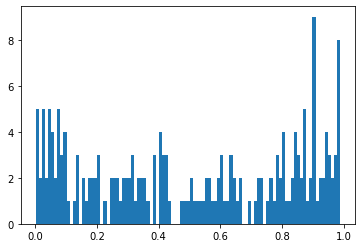

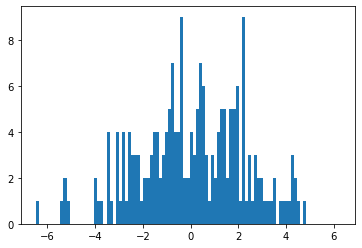

 2.5th percentile: -4.00980104269858
97.5th percentile: 4.337914394490872


In [3]:
########### Section 3 - Data Validation ######################


# Sanity Check 1: Should be equal to signal strength
print('Signal Strength From Data:',Beta.dot(Beta)/n)
print('Assigned Signal Strength:',signal_strength)

# QUICK ASIDE...
# Looking at distribution of means
import matplotlib.pyplot as plt
min_mean = min(means)
max_mean = max(means)
plt.hist(means, bins=np.arange(min_mean, max_mean, (max_mean-min_mean)/100))
plt.show()


# Looking at distribution of systematic components (would prefer to call these the "means")
sys_comp = X.dot(Beta)
min_sys_comp = min(sys_comp)
max_sys_comp = max(sys_comp)
plt.hist(sys_comp, bins=np.arange(min_sys_comp, max_sys_comp, (max_sys_comp-min_sys_comp)/100))
plt.show()

# Checking percentiles of 'sys_comp'. For signal strength of 5, 2.5th percentile should be > ~-4.472
# and 97.5th percentile should be < ~4.472
print(' 2.5th percentile: '+str(np.percentile(sys_comp,2.5)))
print('97.5th percentile: '+str(np.percentile(sys_comp,97.5)))

In [4]:
########## SECTION 4 - Probe Frontier ############################################

# Given a data sample (y_i, X_i), start by choosing a "fine grid" of kappas <= 1/2
# Here we can choose the kappa_grid_size and the lower and upper bound of the grid will be automatic

grid_step_size = 0.01

dec_count = str(grid_step_size)[::-1].find('.')
min_kappa = np.around(p/n,dec_count)
if min_kappa>0.5:
    sys.exit("Add more observations or reduce predictors!")
else:
    max_kappa = 0.51
    
kappaArray = np.arange(min_kappa,max_kappa,grid_step_size)



# Initializing list to hold proportions of times MLE *** does not **** exist at each kappa
kappaProportion = []

d1 = time.time()

# For each k_j in the grid, we do the following:
for kappa in kappaArray:
    
    # Set sample size to n_j =p / k_j (rounding off to nearest integer)
    sampleSize = int(round(p/kappa))

    # Here, we draw several samples and check to see if the MLE exists. B is the number of
    # rounds of sampling
    B = 50
    
    # nMleDNE is the total number of times the MLE *** Does Not Exist *** for each kappa (k_j). This
    # is initially set to 0
    nMleDNE = 0
    
    for i in range(B):
        subSample = df.sample(n=sampleSize) # draw the subsample
        subSample =subSample.reset_index(drop = True) # Reindexing is necessary because df.sample draws 
                                                        # the index from the original dataframe
        
        mleStatus = checkMleExistence(subSample) # check if MLE exists
        # Note that checkMleExistence returns a coded value. The list of coded values can be
        # found here: https://www.gurobi.com/documentation/9.0/refman/optimization_status_codes.html
        # We are most interested in the number of times (out of B times) MLE does not exist.
        # If MLE does not exist, the checkMleExistence function will return status code 2 indicating that the 
        # LP has an optimal solution. 
        
        if mleStatus == 2:
            nMleDNE +=1
            
    # Dividing nMleExist by B gives an estimate of the proportion of times the MLE does not exist.
    propMleDNE = nMleDNE/B
    kappaProportion.append(propMleDNE)
    

# Now, we need (kappa_j-1, kappa_j) such that kappa_j is the smallest value (kappa) for which 
# the proportion of times the MLE does not exist is greater than or equals to 0.5

uIdx = 0 #index of kappa_j, initially set to zero

for kappaProp in kappaProportion:
    if kappaProp>=0.5: # First occuence of 0.5 or higher
        uIdx = kappaProportion.index(kappaProp) # index of kappa_j
        break

if uIdx != 0:
    uKappa = kappaArray[uIdx] # kappa_j: Upper Bound of Kappa
    lKappa = kappaArray[uIdx-1] # kappa_j-1: Lower Bound of Kappa
else: # If there is no kappa for which the proportion is 0.5 or higher or vice versa
    print('kappa proportions:', kappaProportion)
    print('Time for the Code to run:',delta)
    sys.exit("Method Failed, Try again changing n,p, and B!")

d2 = time.time()
delta = round(d2 - d1)
print('Lower Bound of Kappa:',lKappa)
print('Upper Bound of Kappa:',uKappa)
print('Kappa can be found by averaging the lower and upper bound or even setting the upper bound conservatively')
kappaHat = np.around((lKappa + uKappa)/2,dec_count+1)
print('Kappa Hat:',kappaHat)
print('kappa proportions:', kappaProportion)
print('Time for the Code to run:',delta)

Using license file C:\Users\laure\gurobi.lic
Academic license - for non-commercial use only
Lower Bound of Kappa: 0.3100000000000001
Upper Bound of Kappa: 0.3200000000000001
Kappa can be found by averaging the lower and upper bound or even setting the upper bound conservatively
Kappa Hat: 0.315
kappa proportions: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.02, 0.2, 0.2, 0.24, 0.28, 0.6, 0.54, 0.62, 0.76, 0.84, 0.88, 0.92, 0.94, 0.98, 0.98, 1.0, 1.0, 1.0, 1.0, 0.96, 1.0, 1.0, 1.0, 1.0]
Time for the Code to run: 160


In [26]:
grid_step_size = 0.01

dec_count = str(grid_step_size)[::-1].find('.')
min_kappa = np.around(p/n,dec_count)
if min_kappa>0.5:
    sys.exit("Add more observations or reduce predictors!")
else:
    max_kappa = 0.51
    
kappaArray = np.arange(min_kappa,max_kappa,grid_step_size)
gammaArray = np.arange(0.5,10,0.5)

n=200
p=40
mu = 0
stdev = 1.0
kappaProportion = []
for gamma in gammaArray:
    kappa_=[]
    X, Beta, y, means = generateData(dist = 'bernoulli', n = n, p = p, mu = mu, stdev = stdev, signal_strength = gamma)
    df = pd.DataFrame(X)
    y = np.array(y)
    y = np.where(y>0,1,-1)
    df['y'] = pd.Series(y)
    
    for kappa in kappaArray:
    
        sampleSize = int(round(p/kappa))
        B = 50
        nMleDNE = 0

        for i in range(B):
            subSample = df.sample(n=sampleSize) 
            subSample =subSample.reset_index(drop = True)         
            mleStatus = checkMleExistence(subSample) 
            if mleStatus == 2:
                nMleDNE +=1

        propMleDNE = nMleDNE/B
        kappa_.append(propMleDNE)
    kappaProportion.append(kappa_)
    

In [27]:
np.savetxt("kappaProportion.csv", kappaProportion, delimiter=",")

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
gamma=[]

for i in gammaArray:
    g=round(i,2)
    gamma.append(g)

    kappa=[]

for i in kappaArray:
    k=round(i,2)
    kappa.append(k)

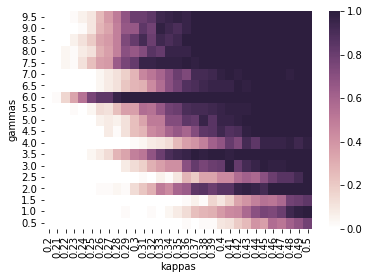

In [31]:
proportions=np.array(kappaProportion) 
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
heat_map=sns.heatmap(proportions, xticklabels=kappa, yticklabels=gamma,cmap=cmap)
plt.gca().invert_yaxis()
plt.xlabel("kappas")
plt.ylabel("gammas")
plt.show()